# Tutorial 07: Compare with Thompson sampling
We will compare SOBER with Thompson sampling

### 0. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import copy
import torch
import warnings
import matplotlib.pyplot as plt
from SOBER._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

### 1. Visualise the true function surface

In [2]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

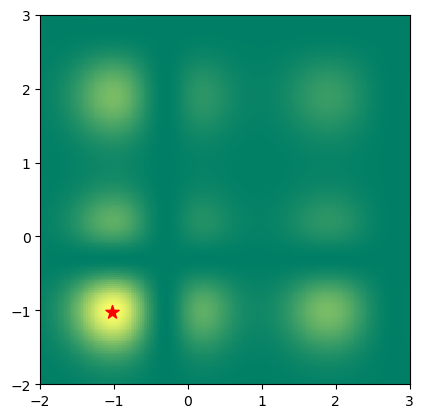

In [3]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

def get_plotting_domain():
    x = torch.linspace(lower_limit, upper_limit, resolution)
    y = torch.linspace(lower_limit, upper_limit, resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[lower_limit, upper_limit, lower_limit, upper_limit],
        interpolation='nearest',
        origin='lower',
    )
    ax.scatter(ground_truth[1], ground_truth[0], s=100, marker="*", color="red")

def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="white")

def plot_black(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="black")
    
fig, ax = plt.subplots()
Xgrid = get_plotting_domain()
Ygrid = BraninFunction(Xgrid)
plot_function(Ygrid, ax)
plt.show()

### 2. Set functions

In [4]:
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.constraints import Interval
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from SOBER._sober import Sober

def set_rbf_model(X, Y):
    """
    Set up the Gaussian process model with RBF kernel.
    
    Args:
    - X: torch.tensor, the observed input X
    - Y: torch.tensor, the observed outcome Y
    
    Return:
    - model: gpytorch.models, function of GP model.
    """
    base_kernel = RBFKernel()
    covar_module = ScaleKernel(base_kernel)

    # Fit a GP model
    train_Y = (Y - Y.mean()) / Y.std()
    train_Y = train_Y.view(-1).unsqueeze(1)
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X, train_Y, likelihood=likelihood, covar_module=covar_module)
    if tm.is_cuda():
        return model.cuda()
    else:
        return model

def optimise_model(model):
    """
    Optimise the hyperparameters of Gaussian process model using L-BFGS-B (BoTorch optimizer)
    
    Args:
    - model: gpytorch.models, the optimised GP model.
    
    Return:
    - model: gpytorch.models, the optimised GP model.
    """
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return model

def predict(test_x, model):
    model.eval()
    model.likelihood.eval()

    try:
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = model.likelihood(model(test_x))
    except:
        warnings.warn("Cholesky failed. Adding more jitter...")
        with torch.no_grad(), gpytorch.settings.cholesky_jitter(float=1e-2):
            pred = model.likelihood(model(test_x))
    return pred.mean, pred.variance

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [5]:
from botorch.generation import MaxPosteriorSampling
from SOBER._gp import predict
y_true = tm.standardise_tensor(BraninFunction(ground_truth))

def regret_analysis(w_batch, X_batch, weights, X_cand):
    # Bayesian regret
    BR = (y_true - w_batch @ BraninFunction(X_batch)).abs()
    
    # pi shrinkage
    pi_mean = weights @ X_cand
    data_covariance = (X_cand - pi_mean) @ (X_cand - pi_mean).T
    MV = weights @ data_covariance.diag()
    return BR, MV
    
def run_sober(sober, X, Y):
    start = time.monotonic()
    model = set_rbf_model(X, Y) # GP model with RBF kernel
    model = optimise_model(model) # Optimise hyperparameters
    sober.update_model(model)
    
    # sampling from pi
    X_cand, weights = sober.sampling(n_rec)              # 1st and 2nd step
    sober.update_prior(X_cand, weights)                  # 3rd step
    X_cand, weights = sober.recursive_sampling(n_rec)    # 4th step
    
    # sampling for Nyström approximation
    idx_nys = sober.deweighted_resampling(weights, n_nys) # deweighted sampling
    X_nys = X_cand[idx_nys]
    
    # sampling for batch queries
    idx_batch, w_batch = sober.sampling_recombination(
        X_cand,
        X_nys,
        weights,
        batch_size,
        calc_obj=None,
    )
    X_batch = X_cand[idx_batch]
    end = time.monotonic()
    interval = end - start
    # regret analysis
    BR, MV = regret_analysis(w_batch, X_batch, weights, X_cand)    
    
    # visualisation
    Ygrid_pi = sober.pi(Xgrid)
    logpi = (Ygrid_pi + torch.finfo().eps).log()
    return sober, X_batch, BR, MV, logpi, interval

def run_ts(X, Y):
    start = time.monotonic()
    model = set_rbf_model(X, Y) # GP model with RBF kernel
    model = optimise_model(model) # Optimise hyperparameters
    X_cand = prior.sample(n_rec)
    with gpytorch.settings.max_cholesky_size(float("inf")), torch.no_grad():
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        X_batch = thompson_sampling(X_cand, num_samples=batch_size)
    end = time.monotonic()
    interval = end - start
    BR = (y_true - BraninFunction(X_batch).mean()).abs()
    Ygrid_mu, Ygrid_var = predict(Xgrid, model)
    UCB = Ygrid_mu + 0.2*Ygrid_var
    return X_batch, BR, UCB, interval

In [6]:
def visualise(
    n_iter,
    logpi, 
    UCB, 
    Xall_sober, 
    X_batch_sober,
    results_sober,
    Xall_ts,
    X_batch_ts,
    results_ts,
):
    fig, axes = plt.subplots(
        3, 
        2, 
        gridspec_kw={
            'width_ratios': [1, 1],
            'height_ratios': [1, 1, 1],
            'wspace': 0,
        },
        #tight_layout=True,
        figsize=(9,6),
    )
    fsize = 10
    plot_function(Ygrid, axes[0,1])
    plot_white(Xinit, axes[0,1])
    axes[0,1].set_ylabel("true Branin function")
    axes[0,1].yaxis.set_label_position("right")
    axes[0,1].set_xticklabels([])
    axes[0,1].set_yticklabels([])
    axes[0,1].set_xticks([])
    axes[0,1].set_yticks([])
    axes[0,1].set_aspect('equal')
        
    plot_function(UCB, axes[1,1])
    plot_white(Xall_ts, axes[1,1])
    plot_black(X_batch_ts, axes[1,1])
    axes[1,1].set_ylabel("Thompson Sampling")
    axes[1,1].yaxis.set_label_position("right")
    axes[1,1].set_xticklabels([])
    axes[1,1].set_yticklabels([])
    axes[1,1].set_xticks([])
    axes[1,1].set_yticks([])
    axes[1,1].set_aspect('equal')
    
    plot_function(logpi, axes[2,1])
    plot_white(Xall_sober, axes[2,1])
    plot_black(X_batch_sober, axes[2,1])
    axes[2,1].set_ylabel("SOBER")
    axes[2,1].yaxis.set_label_position("right")
    axes[2,1].set_xticklabels([])
    axes[2,1].set_yticklabels([])
    axes[2,1].set_xticks([])
    axes[2,1].set_yticks([])
    axes[2,1].set_aspect('equal')
    
    idx_batch = torch.arange(n_iter+1)
    results_sober = torch.tensor(results_sober)
    results_ts = torch.tensor(results_ts)

    axes[0,0].plot(idx_batch, results_ts[:,2], 'ko-', label="TS")
    axes[0,0].plot(idx_batch, results_sober[:,2], 'bo-', label="SOBER")
    axes[0,0].legend()
    axes[0,0].set_ylabel("Bayesian regret")
    axes[0,0].set_yscale('log')
    axes[0,0].set_xlim([0, 4])
    axes[0,0].set_ylim([4e-5, 60])
    axes[0,0].set_xticklabels([])
    
    axes[1,0].plot(idx_batch, results_ts[:,0], 'ko-', label="TS")
    axes[1,0].plot(idx_batch, results_sober[:,0], 'bo-', label="SOBER")
    axes[1,0].legend()
    axes[1,0].set_ylabel("Overhead [s]")
    axes[1,0].set_xlim([0, 4])
    axes[1,0].set_ylim([0, 50])
    axes[1,0].set_xticklabels([])

    axes[2,0].plot(idx_batch, results_sober[:,3], 'bo-')
    axes[2,0].set_xlabel("number of batches")
    axes[2,0].set_ylabel("Variance of measure")
    axes[2,0].set_yscale('log')
    axes[2,0].set_xlim([0, 4])
    axes[2,0].set_ylim([1e-6, 10])
    
    fig.subplots_adjust(wspace=0, hspace=0)
    fig.canvas.draw()
    axpos1 = axes[0,1].get_position()
    axpos2 = axes[1,1].get_position()
    axpos3 = axes[2,1].get_position()
    axes[0,0].set_position([axpos1.x0 - axpos1.width, axpos1.y0, axpos1.width, axpos1.height])
    axes[1,0].set_position([axpos1.x0 - axpos1.width, axpos2.y0, axpos1.width, axpos1.height])
    axes[2,0].set_position([axpos1.x0 - axpos1.width, axpos3.y0, axpos1.width, axpos1.height])

### 3. Set experimental conditions

In [7]:
# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

# initial sampling
random_seed = 5  #10   # random seed that determines random behaviours
torch.manual_seed(random_seed)

n_init = 10        # number of initial samples
Xinit = prior.sample(n_init)
Yinit = BraninFunction(Xinit)

# set experimental conditions
batch_size = 30    # number of batch samples
n_rec = 20000      # number of candidates sampled from pi
n_nys = 500        # number of samples for Nyström approximation
n_iterations = 5   # number of iterations (batches)

### 4. Run comparisons

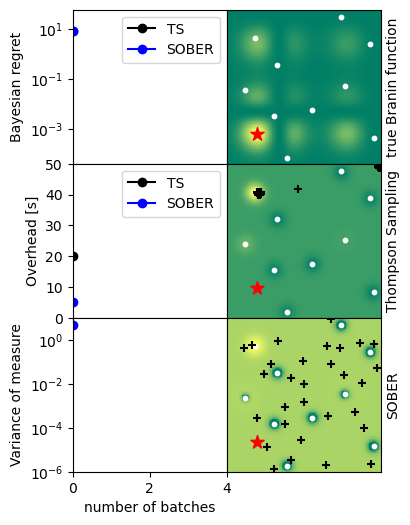

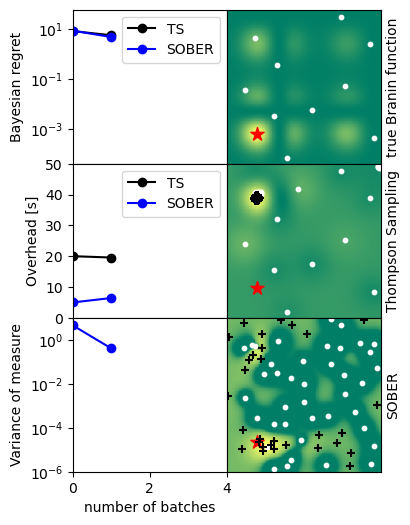

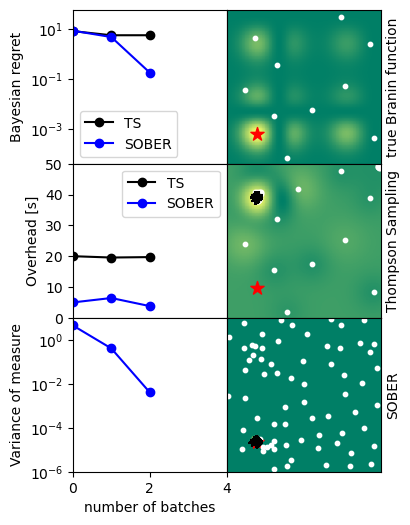

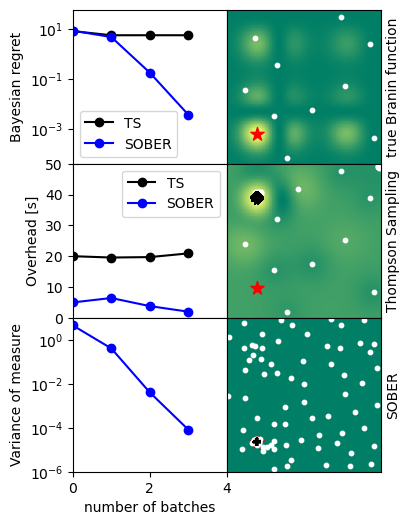

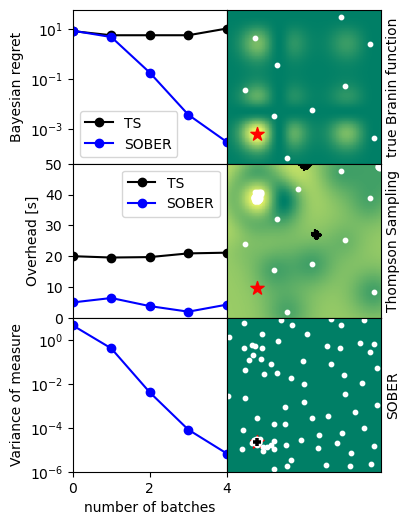

In [8]:
Xall_sober = copy.deepcopy(Xinit)
Yall_sober = copy.deepcopy(Yinit)
Xall_ts = copy.deepcopy(Xinit)
Yall_ts = copy.deepcopy(Yinit)

model_sober = set_rbf_model(Xall_sober, Yall_sober)
sober = Sober(prior, model_sober)

results_sober = []
results_ts = []
for n_iter in range(n_iterations):
    sober, X_batch_sober, BR_sober, MV, logpi, interval_sober = run_sober(sober, Xall_sober, Yall_sober)
    X_batch_ts, BR_ts, UCB, interval_ts = run_ts(Xall_ts, Yall_ts)
    
    results_sober.append([
        interval_sober,          # the computational overhead
        Yall_sober.max().item(), # the maximum
        BR_sober.item(),         # Bayesian regret
        MV.item(),               # variance of pi
    ])
    results_ts.append([
        interval_ts,          # the computational overhead
        Yall_ts.max().item(), # the maximum
        BR_ts.item(),         # Bayesian regret
    ])
    visualise(
        n_iter,
        logpi, 
        UCB, 
        Xall_sober, 
        X_batch_sober,
        results_sober,
        Xall_ts,
        X_batch_ts,
        results_ts,
    )
    #plt.savefig("demo"+str(n_iter)+".png", dpi=150)
    plt.show()
    
    Y_batch_sober = BraninFunction(X_batch_sober)
    Xall_sober = torch.cat((Xall_sober, X_batch_sober), dim=0)
    Yall_sober = torch.cat((Yall_sober, Y_batch_sober), dim=0)
    Y_batch_ts = BraninFunction(X_batch_ts)
    Xall_ts = torch.cat((Xall_ts, X_batch_ts), dim=0)
    Yall_ts = torch.cat((Yall_ts, Y_batch_ts), dim=0)

As we can see, SOBER can robustly find the global optimum both more sample-efficiently and quickly than Thompson sampling.<br>
You can check the robustness by changing the random seed and conditions